In [22]:
!pip install pmdarima prophet -q

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from prophet import Prophet

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
warnings.filterwarnings("ignore")

In [27]:
def load_and_merge_data():
    """
    Loads, cleans, and merges the 6 CSV files into a master dataframe.
    """
    file_map = {
        'inflation_rate.csv': 'Inflation',
        'fed_funds_rate.csv': 'Fed_Funds_Rate',
        'money_supply_M2.csv': 'Money_Supply_M2',
        'oil_price_wti.csv': 'Oil_Price',
        'ppi_all_commodities.csv': 'PPI',
        'unemployment_rate.csv': 'Unemployment'
    }

    master_df = pd.DataFrame()

    # Load Base File (Inflation)
    try:
        base_df = pd.read_csv('inflation_rate.csv')
        base_df['Date'] = pd.to_datetime(base_df['Date'])
        base_df = base_df.rename(columns={'Inflation_YoY (%)': 'Inflation'})
        master_df = base_df[['Date', 'Inflation']]
    except FileNotFoundError:
        print("CRITICAL ERROR: 'inflation_rate.csv' not found. Please upload dataset.")
        return None

    # Merge Other Files
    for filename, new_col in file_map.items():
        if filename == 'inflation_rate.csv': continue
        try:
            df_temp = pd.read_csv(filename)
            df_temp['Date'] = pd.to_datetime(df_temp['Date'])
            val_col = [c for c in df_temp.columns if c != 'Date'][0]
            df_temp = df_temp.rename(columns={val_col: new_col})
            master_df = pd.merge(master_df, df_temp, on='Date', how='inner')
        except FileNotFoundError:
            print(f"Warning: File {filename} not found.")

    # Final Clean: Sort by Date and drop initial NaNs
    master_df = master_df.dropna().sort_values('Date').reset_index(drop=True)
    print(f"Data Loaded. Shape: {master_df.shape}")
    return master_df

In [28]:
def feature_engineering(df):
    """
    Creates Lag Features for ML and Shifted Regressors for Prophet.
    CRITICAL: This handles the "future data leakage" issue.
    """
    df_eng = df.copy()

    # Define Regressors (Helpers)
    regressors = ['Fed_Funds_Rate', 'Money_Supply_M2', 'Oil_Price', 'PPI', 'Unemployment']

    # 1. Create SHIFTED regressors for Prophet
    # We shift them by 1 month so we use t-1 to predict t.
    for col in regressors:
        df_eng[f'{col}_shifted'] = df_eng[col].shift(1)

    # 2. Create LAG features for Random Forest
    # Lags: 1, 2, 3, 6, 12 months
    lags = [1, 2, 3, 6, 12]
    for col in ['Inflation'] + regressors:
        for lag in lags:
            df_eng[f'{col}_lag_{lag}'] = df_eng[col].shift(lag)

    # Drop rows with NaNs created by shifting/lagging
    df_eng = df_eng.dropna().reset_index(drop=True)
    return df_eng

In [29]:
def evaluate(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"   -> {name} RMSE: {rmse:.4f}")
    return rmse, y_pred


In [30]:
def run_arima(train, test):
    print("\n--- Running ARIMA (Classic Statistical) ---")
    print("Optimization: Using auto_arima to find best (p,d,q)...")

    # Auto-ARIMA (The Robot)
    model = auto_arima(train['Inflation'], seasonal=True, m=12,
                       test='adf', suppress_warnings=True, stepwise=True)
    print(f"Best ARIMA Order: {model.order}")

    # Diagnostics (Professor requested check of residuals)
    print("Checking Residuals...")
    model.plot_diagnostics(figsize=(10, 8))
    plt.show()

    # Predict
    pred = model.predict(n_periods=len(test))
    return evaluate(test['Inflation'], pred, "ARIMA")

In [31]:
def run_prophet(df_prophet, split_date):
    print("\n--- Running Prophet (Modern Component) ---")
    print("Correction: Using SHIFTED regressors (t-1) to prevent data leakage.")

    # Rename cols for Prophet
    df_p = df_prophet.rename(columns={'Date': 'ds', 'Inflation': 'y'})

    # Honest Train/Test Split (Same dates as ARIMA)
    train = df_p[df_p['ds'] <= split_date]
    test = df_p[df_p['ds'] > split_date]

    m = Prophet(interval_width=0.95)

    # Add only the SHIFTED regressors
    shifted_regs = [c for c in df_p.columns if '_shifted' in c]
    for reg in shifted_regs:
        m.add_regressor(reg)

    m.fit(train)
    forecast = m.predict(test)

    m.plot(forecast)
    plt.show()

    return evaluate(test['y'], forecast['yhat'], "Prophet")

In [32]:
def run_random_forest_correct(df_ml, split_date):
    print("\n--- Running Random Forest (Machine Learning) ---")
    print("Method: 1. Tune Hyperparameters on Train (Cross-Validation).")
    print("        2. Train ONE final model on Train.")
    print("        3. Evaluate ONCE on Test.")

    # Prepare Data
    # Drop 'Date', 'Inflation' (Target), and original unshifted regressors (Leakage risk)
    drop_cols = ['Date', 'Inflation', 'Fed_Funds_Rate', 'Money_Supply_M2', 'Oil_Price', 'PPI', 'Unemployment']
    X = df_ml.drop(columns=[c for c in drop_cols if c in df_ml.columns])
    y = df_ml['Inflation']

    # Honest Train/Test Split
    mask_train = df_ml['Date'] <= split_date
    mask_test = df_ml['Date'] > split_date

    X_train, y_train = X[mask_train], y[mask_train]
    X_test, y_test = X[mask_test], y[mask_test]

    # 1. Hyperparameter Tuning using TimeSeriesSplit (Cross-Validation) on TRAINING DATA ONLY
    tscv = TimeSeriesSplit(n_splits=3)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    }

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    grid = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)

    print("Tuning Hyperparameters...")
    grid.fit(X_train, y_train)
    print(f"Best Parameters Found: {grid.best_params_}")

    # 2. Train Final Model using Best Parameters
    final_model = grid.best_estimator_

    # 3. Final Evaluation on Test Set
    y_pred = final_model.predict(X_test)

    # Feature Importance Plot
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[-10:]
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Drivers of Inflation (Feature Importance)')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    plt.xlabel('Importance')
    plt.show()

    return evaluate(y_test, y_pred, "Random Forest")


Data Loaded. Shape: (288, 7)

Training Data: 2000 to 2021-12-31
Testing Data:  2022 to 2024 (Common for ALL models)

--- Running ARIMA (Classic Statistical) ---
Optimization: Using auto_arima to find best (p,d,q)...
Best ARIMA Order: (1, 0, 1)
Checking Residuals...


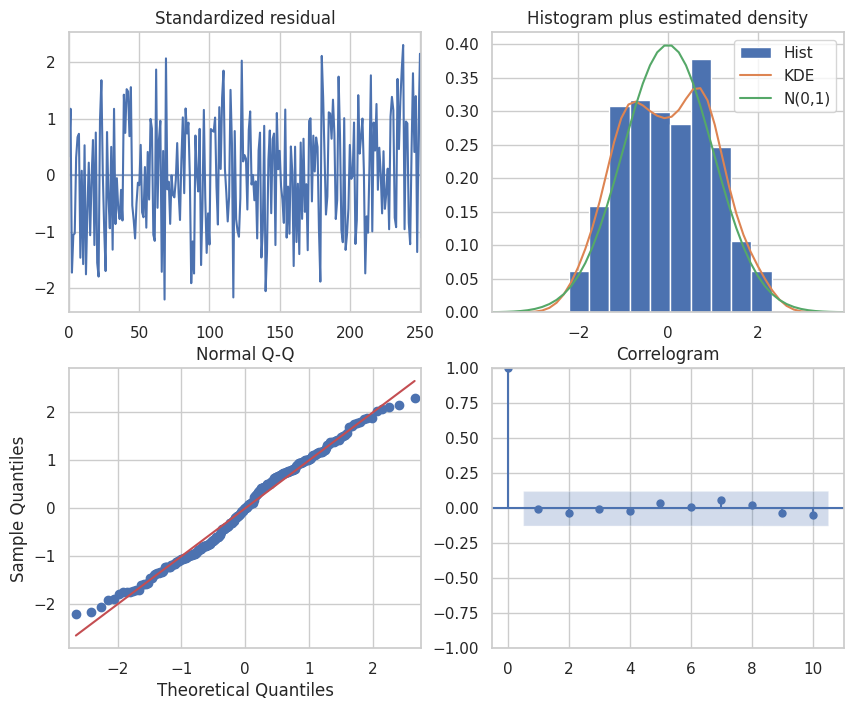

   -> ARIMA RMSE: 0.6934

--- Running Prophet (Modern Component) ---
Correction: Using SHIFTED regressors (t-1) to prevent data leakage.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


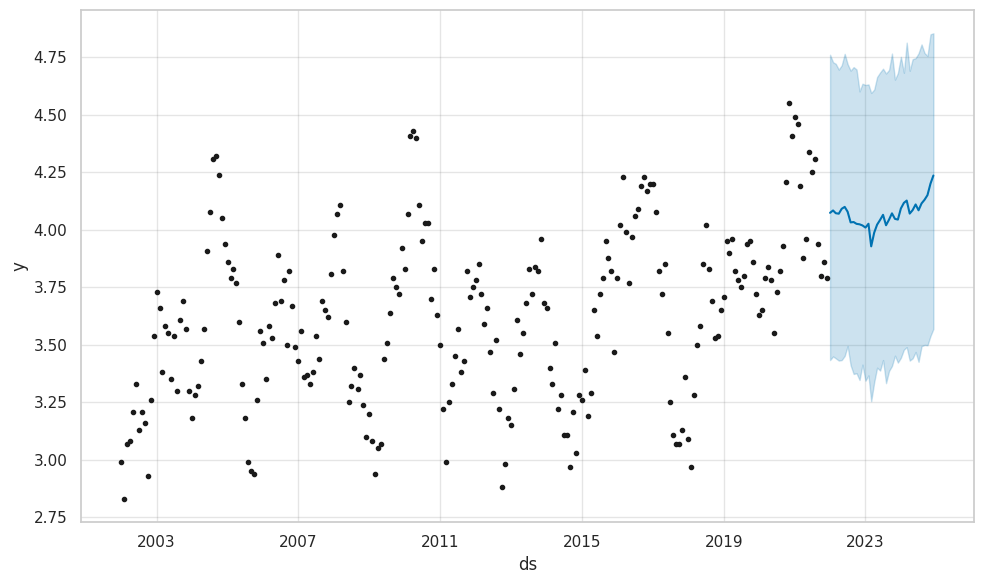

   -> Prophet RMSE: 0.6484

--- Running Random Forest (Machine Learning) ---
Method: 1. Tune Hyperparameters on Train (Cross-Validation).
        2. Train ONE final model on Train.
        3. Evaluate ONCE on Test.
Tuning Hyperparameters...
Best Parameters Found: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


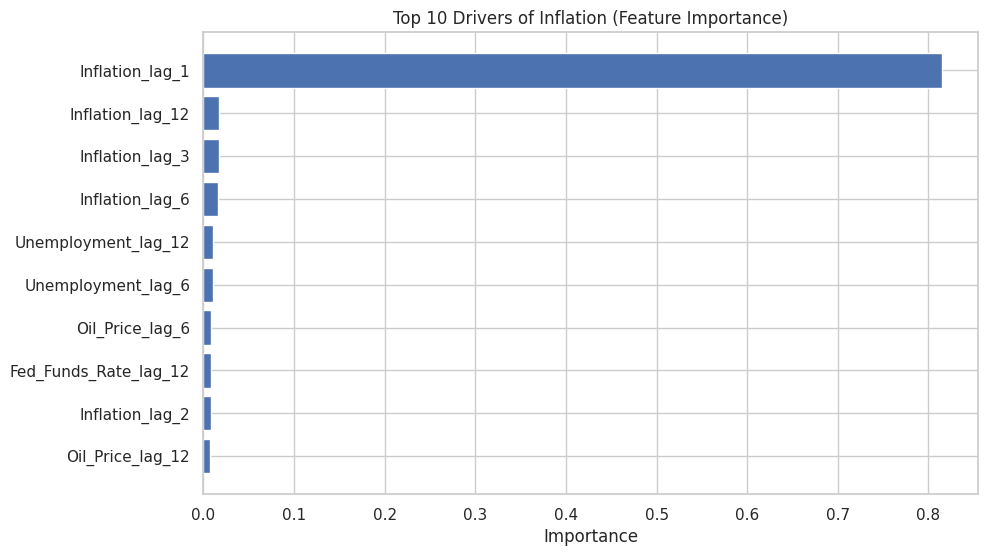

   -> Random Forest RMSE: 0.2636


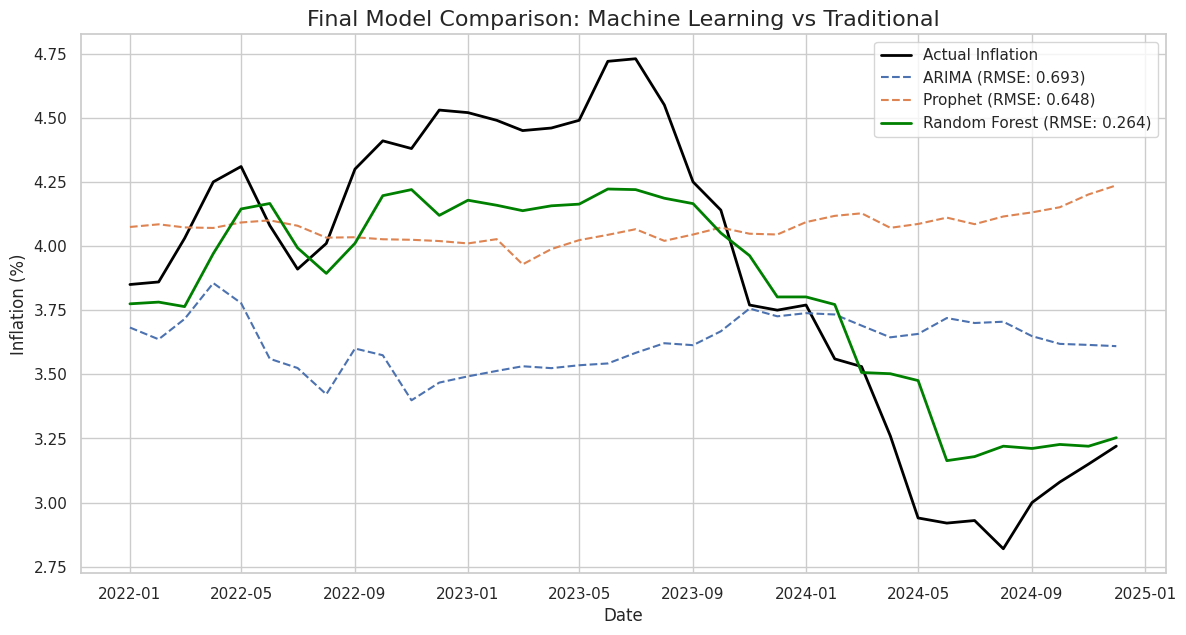


🏆 FINAL SCOREBOARD 🏆
1. Random Forest RMSE: 0.2636
2. ARIMA RMSE:         0.6934
3. Prophet RMSE:       0.6484


In [34]:
# the final pipeline.
# 1. Load Data
df = load_and_merge_data()

if df is not None:
    # 2. Feature Engineering
    df_eng = feature_engineering(df)

    # DEFINE COMMON SPLIT DATE (Crucial for "Honest Comparison")
    SPLIT_DATE = '2021-12-31'
    print(f"\nTraining Data: 2000 to {SPLIT_DATE}")
    print("Testing Data:  2022 to 2024 (Common for ALL models)")

    # 3. Run Models
    # A. ARIMA
    train_arima = df[df['Date'] <= SPLIT_DATE]
    test_arima = df[df['Date'] > SPLIT_DATE]
    rmse_arima, pred_arima = run_arima(train_arima, test_arima)

    # B. Prophet
    rmse_prophet, pred_prophet = run_prophet(df_eng, SPLIT_DATE)

    # C. Random Forest
    rmse_rf, pred_rf = run_random_forest_correct(df_eng, SPLIT_DATE)

    # 4. Final Comparison Plot
    plt.figure(figsize=(14, 7))
    test_dates = df_eng[df_eng['Date'] > SPLIT_DATE]['Date']
    actuals = df_eng[df_eng['Date'] > SPLIT_DATE]['Inflation']

    plt.plot(test_dates, actuals, label='Actual Inflation', color='black', linewidth=2)
    plt.plot(test_dates, pred_arima, label=f'ARIMA (RMSE: {rmse_arima:.3f})', linestyle='--')
    plt.plot(test_dates, pred_prophet, label=f'Prophet (RMSE: {rmse_prophet:.3f})', linestyle='--')
    plt.plot(test_dates, pred_rf, label=f'Random Forest (RMSE: {rmse_rf:.3f})', color='green', linewidth=2)

    plt.title('Final Model Comparison: Machine Learning vs Traditional', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Inflation (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. Final Scoreboard
    print("\n🏆 FINAL SCOREBOARD 🏆")
    print(f"1. Random Forest RMSE: {rmse_rf:.4f}")
    print(f"2. ARIMA RMSE:         {rmse_arima:.4f}")
    print(f"3. Prophet RMSE:       {rmse_prophet:.4f}")

In [38]:
#EXPORT FOR DASHBOARD (NEW SECTION)
print("\n--- Exporting Data for Tableau Dashboard ---")

# The length of the test period (36 months)
expected_length = len(actuals)

# Ensure all predictions are numpy arrays of the correct length
# If a prediction array is shorter, pad it with NaNs.
# If a prediction array is longer, truncate it.

# Helper function to align prediction lengths
def align_prediction_length(prediction_data, target_length):
    if isinstance(prediction_data, pd.Series):
        prediction_data = prediction_data.values
    elif not isinstance(prediction_data, np.ndarray):
        prediction_data = np.array(prediction_data)

    current_length = len(prediction_data)

    if current_length < target_length:
        # Pad with NaNs if shorter than target
        return np.pad(prediction_data, (0, target_length - current_length), 'constant', constant_values=np.nan)
    elif current_length > target_length:
        # Truncate if longer than target
        return prediction_data[:target_length]
    else:
        return prediction_data

# Apply alignment to all forecast arrays
pred_arima_aligned = align_prediction_length(pred_arima, expected_length)
pred_prophet_aligned = align_prediction_length(pred_prophet, expected_length)
pred_rf_aligned = align_prediction_length(pred_rf, expected_length)

# Create a DataFrame with Dates, Actuals, and ALL Forecasts
dashboard_df = pd.DataFrame({
    'Date': test_dates.values,
    'Actual_Inflation': actuals.values,
    'Forecast_ARIMA': pred_arima_aligned,
    'Forecast_Prophet': pred_prophet_aligned,
    'Forecast_RandomForest': pred_rf_aligned
})

# Save to CSV
filename = 'Inflation_Forecast_Results_for_Tableau.csv'
dashboard_df.to_csv(filename, index=False)
print(f"SUCCESS: File '{filename}' has been created.")
print("Please download this file from the 'Files' tab on the left to use in Tableau.")


--- Exporting Data for Tableau Dashboard ---
SUCCESS: File 'Inflation_Forecast_Results_for_Tableau.csv' has been created.
Please download this file from the 'Files' tab on the left to use in Tableau.
